# Project Part B: Representation

![](banner_project.jpg)

In [1]:
analyst = "Charlie Ellis" # Replace this with your name

In [2]:
f = "setup.R"; for (i in 1:10) { if (file.exists(f)) break else f = paste0("../", f) }; source(f)
options(repr.matrix.max.rows=674)
options(repr.matrix.max.cols=200)
update_geom_defaults("point", list(size=1))                                

.................................................... start of document ....................................................

## Directions

### Objective

Transform the representation of a dataset about public company fundamentals.  Later, use the transformed dataset along with additional analysis to recommend a portfolio of 12 company investments that maximizes 12-month return of an overall \$1,000,000 investment.

### Approach

Retrieve a public company fundamentals dataset comprising thousands of US companies from quarters 1, 2, 3, and 4 of year 2017 + company stock price data for those companies from quarter 4 of year 2018.

Transform the dataset representation to capture all information about any single company in a single observation.

Additionally transform the dataset representation using variable filtration, imputation, principal component analysis, and other methods.

### Data Source

The data includes these files:

* Data Dictionary.csv
* Company Fundamentals 2017.csv
* Company Fundamentals 2018.csv

The dataset and accompanying data dictionary was sourced from ...

* Wharton Research Data Services > Compustat - Capital IQ from Standard & Poor's > North America - Daily > Fundamentals Quarterly (https://wrds-www.wharton.upenn.edu/)

  * Date Variable: Data Date
  * Date Range: 2017-01 to 2017-12 -or- 2018-01 to 2018-12
  * Company Codes: Search the entire database
    * Consolidtaion Level: C, Output
    * Industry Format: INDL, FS, Output
    * Data Format: STD, Output
    * Population Source: D, Output
    * Quarter Type: Fiscal View, Output
    * Currency: USD, Output (not CAD)
    * Company Status: Active, Output (not Inactive)
  * Variable Types: Data Items, Select All (674)
  * Query output:
    * Output format: comma-delimited text
    * Compression type: None
    * Data format: MMDDYY10

The dataset is restricted to select US active, publicly held companies that reported quarterly measures including stock prices for 1st, 2nd, 3rd, and 4th quarters in years 2017 and 2018.  All non-missing stock prices exceed $3 per share.  File formats are all comma-separated values (CSV).

The data dictionary is from Variable Descriptions tab, copied to Excel, saved in csv format.

_**For this project, do not source any data from year 2019.**_

## Data

In this part of the data retrieval, we essentially took data from the current year of 2017 and the next year of 2018, and combined them into one data frame which contains market prices for both years, along with a growth column of data representing that company's growth in their stock market price from the current year to the 4th quarter of the future year. Also, we added another column big_growth which says TRUE if that company achieved a growth higher than a specific threshold we listed at 0.30.

In [3]:
threshold = 0.30

In [4]:
# Current Year

datax = read.csv("Company Fundamentals 2017.csv", header=TRUE)

datax$quarter = quarter(mdy(datax[,2]))

data.current.q1 = datax[(datax$quarter==1) & !is.na(datax$prccq) & (datax$prccq>=3), -ncol(datax)]
data.current.q2 = datax[(datax$quarter==2) & !is.na(datax$prccq) & (datax$prccq>=3), -ncol(datax)]
data.current.q3 = datax[(datax$quarter==3) & !is.na(datax$prccq) & (datax$prccq>=3), -ncol(datax)]
data.current.q4 = datax[(datax$quarter==4) & !is.na(datax$prccq) & (datax$prccq>=3), -ncol(datax)]

data.current.q1 = data.current.q1[!duplicated(data.current.q1$gvkey),]
data.current.q2 = data.current.q2[!duplicated(data.current.q2$gvkey),]
data.current.q3 = data.current.q3[!duplicated(data.current.q3$gvkey),]
data.current.q4 = data.current.q4[!duplicated(data.current.q4$gvkey),]

colnames(data.current.q1)[-c(1, 10, 12)] = paste0(colnames(data.current.q1)[-c(1, 10, 12)], ".q1")
colnames(data.current.q2)[-c(1, 10, 12)] = paste0(colnames(data.current.q2)[-c(1, 10, 12)], ".q2")
colnames(data.current.q3)[-c(1, 10, 12)] = paste0(colnames(data.current.q3)[-c(1, 10, 12)], ".q3")
colnames(data.current.q4)[-c(1, 10, 12)] = paste0(colnames(data.current.q4)[-c(1, 10, 12)], ".q4")

m12 = merge(data.current.q1, data.current.q2, by=c("gvkey", "tic", "conm"), all=TRUE)
m34 = merge(data.current.q3, data.current.q4, by=c("gvkey", "tic", "conm"), all=TRUE)
data.current = merge(m12, m34, by=c("gvkey", "tic", "conm"), all=TRUE, sort=TRUE)

data.current = data.current[!is.na(data.current$prccq.q4),]


# Next Year

datax = read.csv("Company Fundamentals 2018.csv", header=TRUE)

datax$quarter = quarter(mdy(datax[,2]))
data.future.q4 = datax[(datax$quarter==4) & !is.na(datax$prccq), c("gvkey", "prccq")]
data.future.q4 = data.future.q4[!duplicated(data.future.q4$gvkey),]


# Consolidated Current Year / Next Year

data = merge(data.current, data.future.q4, by="gvkey", all=FALSE)

data$growth = (data$prccq - data$prccq.q4) / data$prccq.q4
data$big_growth = factor(data$growth >= threshold, levels=c(FALSE, TRUE), labels=c("NO", "YES"))


# Present a few rows ...

data[1:3,]

gvkey,tic,conm,datadate.q1,fyearq.q1,fqtr.q1,fyr.q1,indfmt.q1,consol.q1,popsrc.q1,datafmt.q1,cusip.q1,acctchgq.q1,acctstdq.q1,adrrq.q1,ajexq.q1,ajpq.q1,bsprq.q1,compstq.q1,curcdq.q1,curncdq.q1,currtrq.q1,curuscnq.q1,datacqtr.q1,datafqtr.q1,finalq.q1,ogmq.q1,rp.q1,scfq.q1,srcq.q1,staltq.q1,updq.q1,apdedateq.q1,fdateq.q1,pdateq.q1,rdq.q1,acchgq.q1,acomincq.q1,acoq.q1,actq.q1,altoq.q1,ancq.q1,anoq.q1,aociderglq.q1,aociotherq.q1,aocipenq.q1,aocisecglq.q1,aol2q.q1,aoq.q1,apq.q1,aqaq.q1,aqdq.q1,aqepsq.q1,aqpl1q.q1,aqpq.q1,arcedq.q1,arceepsq.q1,arceq.q1,atq.q1,aul3q.q1,billexceq.q1,capr1q.q1,capr2q.q1,capr3q.q1,capsftq.q1,capsq.q1,ceiexbillq.q1,ceqq.q1,cheq.q1,chq.q1,cibegniq.q1,cicurrq.q1,ciderglq.q1,cimiiq.q1,ciotherq.q1,cipenq.q1,ciq.q1,cisecglq.q1,citotalq.q1,cogsq.q1,csh12q.q1,cshfd12.q1,cshfdq.q1,cshiq.q1,cshopq.q1,cshoq.q1,cshprq.q1,cstkcvq.q1,cstkeq.q1,cstkq.q1,dcomq.q1,dd1q.q1,deracq.q1,deraltq.q1,derhedglq.q1,derlcq.q1,derlltq.q1,diladq.q1,dilavq.q1,dlcq.q1,⋯,stkcpay.q4,tdcy.q4,tfvcey.q4,tiey.q4,tiiy.q4,tsafcy.q4,txachy.q4,txbcofy.q4,txbcoy.q4,txdcy.q4,txdiy.q4,txpdy.q4,txty.q4,txwy.q4,uaolochy.q4,udfccy.q4,udvpy.q4,ufretsdy.q4,ugiy.q4,uniamiy.q4,unopincy.q4,unwccy.q4,uoisy.q4,updvpy.q4,uptacy.q4,uspiy.q4,ustdncy.q4,usubdvpy.q4,utfdocy.q4,utfoscy.q4,utmey.q4,uwkcapcy.q4,wcapchy.q4,wcapcy.q4,wday.q4,wddy.q4,wdepsy.q4,wdpy.q4,xidocy.q4,xidoy.q4,xinty.q4,xiy.q4,xopry.q4,xoptdqpy.q4,xoptdy.q4,xoptepsqpy.q4,xoptepsy.q4,xoptqpy.q4,xopty.q4,xrdy.q4,xsgay.q4,exchg.q4,cik.q4,costat.q4,fic.q4,cshtrq.q4,dvpspq.q4,dvpsxq.q4,mkvaltq.q4,prccq.q4,prchq.q4,prclq.q4,adjex.q4,add1.q4,add2.q4,add3.q4,add4.q4,addzip.q4,busdesc.q4,city.q4,conml.q4,county.q4,dlrsn.q4,ein.q4,fax.q4,fyrc.q4,ggroup.q4,gind.q4,gsector.q4,gsubind.q4,idbflag.q4,incorp.q4,loc.q4,naics.q4,phone.q4,prican.q4,prirow.q4,priusa.q4,sic.q4,spcindcd.q4,spcseccd.q4,spcsrc.q4,state.q4,stko.q4,weburl.q4,dldte.q4,ipodate.q4,prccq,growth,big_growth
1004,AIR,AAR CORP,02/28/2017,2016,3,5,INDL,C,D,STD,000361105,,DS,NA,1,1,,AZ,USD,USD,1,NA,2017Q1,2016Q3,Y,,Q,7,5,,3,02/28/2017,03/23/2017,03/21/2017,03/21/2017,0,-46.400,28.000,893.100,90.500,609.000,NA,0.000,0,-42.500,0,NA,248.500,194.600,NA,NA,NA,NA,NA,NA,NA,NA,1502.100,NA,NA,NA,NA,NA,NA,457.300,NA,885.700,10.100,10.100,13.700,-0.200,0.000,0,0,0.3,13.800,0,13.800,340.70,33.9250,34.2750,34.200,45.170,0.052,34.324,33.700,1.00,-0.1,45.200,0,2.000,NA,NA,NA,NA,NA,0,14.300,2.000,⋯,NA,NA,NA,NA,NA,NA,NA,0,0,-22.100,NA,14.700,11.200,0,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,-1.2,-36.2,3.600,0,758.700,NA,NA,NA,NA,NA,NA,NA,93.300,11,1750,A,USA,13354306,0.075,0.075,1444.0318,41.58,41.940,34.25,1,"One AAR Place, 1100 North Wood Dale Road",,,NA,60191,"AAR Corp. provides products and services to commercial aviation, government, and defense markets worldwide. The company operates in two segments, Aviation Services and Expeditionary Services.",Wood Dale,AAR Corp,,NA,36-2334820,630-227-2039,5,2010,201010,20,20101010,D,DE,USA,423860,630-227-2000,,,1,5080,110,925,B,IL,0,www.aarcorp.com,NA,01/01/1988,43.69,0.05074555,NO
1045,AAL,AMERICAN AIRLINES GROUP INC,03/31/2017,2017,1,12,INDL,C,D,STD,02376R102,,DS,NA,1,1,,AC,USD,USD,1,NA,2017Q1,2017Q1,Y,,Q,7,5,,3,03/31/2017,04/27/2017,,04/27/2017,0,-5097.000,856.000,10626.000,3383.000,42001.000,0,0.000,-669,-4428.000,0,6145,9710.000,1882.000,NA,NA,NA,700,NA,NA,NA,NA,52627.000,0,NA,NA,NA,NA,NA,6726.000,NA,3457.000,7219.000,374.000,340.000,0.000,0.000,0,0,-14.0,326.000,0,326.000,6774.00,526.7220,530.1763,507.797,495.750,11.677,495.750,503.902,0.01,0.0,5.000,0,1714.000,NA,NA,NA,NA,NA,0,340.000,1714.000,⋯,NA,NA,NA,NA,NA,NA,0.000,0,0,1141.000,2089.000,20.000,2113.000,0,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0.0,0.0,1102.000,0,35640.000,NA,NA,NA,NA,NA,NA,NA,7240.000,14,6201,A,USA,270496454,0.100,0.100,24740.6812,52.03,53.740,45.27,1,1 Skyview Drive,,,NA,76155,"American Airlines Group Inc., through its subsidiaries, operates as a network air carrier. It provide

In [5]:
# Identify which variables can later be used as
# outcome variables and which can be used as predictor variables.

outvars = c("prccq", "growth", "big_growth")
prevars = setdiff(colnames(data), outvars)
layout(fmt(outvars), fmt(prevars[1:10], "prevars (first few)"))

outvars
prccq
growth
big_growth
prevars (first few)
gvkey
tic
conm
datadate.q1
fyearq.q1
fqtr.q1


## Transform Representation of Data

In this particular data retrieval, we filtered the data by columns that had at least 80% non-missing values (also a maximum of 20% NA's in the column) or else we dropped that column from our newly created dataset. Next, we imputed our dataset based on a function that takes the mean of columns that are numeric, and the mode for columns that are not numeric, so we can replace the rest of the NA values in our dataset with either a mean or mode value so we don't have to deal with NA values. Next, before we began PCA, we filtered the data again to drop out values that are not numeric and have a variance of zero so we can perform PCA without any data that may cause a skew or some sort of mess up. Then, we computed PCA on our newer, scaled dataset, and took the first 20 pricipal components and visualized them on a bar chart. We saw that PC1 was the highest by quite a bit relative to the others. Then, we combined the company data from before with the first two PCs of the principal components data, and created a scatter plot of all the companies, their first two principal components, and whether than company achieved a big_growth (growth percentage above 30% in the past year). And finally, we transformed our data together in one data frame which has the 5 predictor variables and the 3 outcome variables we want, including the first two principal components.

### Variable Filtration

In [6]:
# Filter the data to include only predictor variables with at least 80% non-missing values. 
# Keep the variable names from the resulting dataset for later use.
# How many observations and variables in the resulting dataset?
#
# You can use the var_info.na_count() function.

# Have 4305 Observations. Cannot have more NA values than t

t = 0.2*4305

data.p = data[,prevars]
data.filtered = data.p[,var_info.na_count(data.p)<=t]
size(data.filtered)

observations,variables
4305,923


### Imputation

In [7]:
# Impute missing data:
# for each numeric variable, use the mean of non-missing values;
# for each non-numeric variable, use the mode of non-missing values.
# Keep the impute values used for each variable for future use.
#
# You can use the get_impute() and impute() functions.
# get_impute(data) provides a vector of means and modes, one for each variable of data.
# impute(data) provides a table like data, but imputed with means and modes.
df = impute(data.filtered)
data_after_imputation = size(df)
fmt(data_after_imputation)

observations,variables
4305,923


### Principal Component Analysis

In [8]:
# For principal component analysis, filter the data to include only numeric and integer variables with non-zero variance.
# How many observations and variables?

df_numeric = df[,sapply(df, is.numeric)]
data_only_numeric = size(df_numeric)
fmt(data_only_numeric)



df_v = df_numeric[,sapply(df_numeric, var) > 0]
data_after_removing_0_var = size(df_v)
fmt(data_after_removing_0_var)


observations,variables
4305,745


observations,variables
4305,737


In [9]:
# Perform a principal component analysis on the numeric and integer variables with non-zero variance
# (use scale=TRUE).
# Keep the centroids and weight matrix for later use.
# Present the first few observations represented as principal components.
# For some principal components, +/- may be different than as shown in the expected output.
df = df_v

pc = prcomp(df, scale=TRUE)

head(pc$x)

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100,⋯,PC638,PC639,PC640,PC641,PC642,PC643,PC644,PC645,PC646,PC647,PC648,PC649,PC650,PC651,PC652,PC653,PC654,PC655,PC656,PC657,PC658,PC659,PC660,PC661,PC662,PC663,PC664,PC665,PC666,PC667,PC668,PC669,PC670,PC671,PC672,PC673,PC674,PC675,PC676,PC677,PC678,PC679,PC680,PC681,PC682,PC683,PC684,PC685,PC686,PC687,PC688,PC689,PC690,PC691,PC692,PC693,PC694,PC695,PC696,PC697,PC698,PC699,PC700,PC701,PC702,PC703,PC704,PC705,PC706,PC707,PC708,PC709,PC710,PC711,PC712,PC713,PC714,PC715,PC716,PC717,PC718,PC719,PC720,PC721,PC722,PC723,PC724,PC725,PC726,PC727,PC728,PC729,PC730,PC731,PC732,PC733,PC734,PC735,PC736,PC737
3.4371231,-0.2260719,0.4220180,-0.6326422,1.5550509,-0.5650989,2.0762355,-4.7809366,2.57837534,1.08343819,-1.0852790,-0.7351277,0.2918953,6.8480433,-1.3871612,1.1200720,0.2210991,0.9914828,-0.79834108,0.20001133,-0.31771792,1.0539380,1.67813281,-0.8672219,-0.37905631,-1.16129629,1.0867702,-1.0412642,0.8547673,-0.1336883,-0.9056983,0.2780267,-0.72462144,-0.018625133,-1.0475663,0.37038314,0.09388485,1.00864500,-0.6290530,0.56007039,-0.13098834,0.52265832,-1.7038187,2.7211571,-0.34390112,0.227859079,-0.09971139,-0.57797892,-0.29036026,0.21928328,-0.47636356,-0.1945795,-0.05066614,-0.07005866,0.4389614,-0.2723389,-0.099977768,-0.315330206,-0.6652111,0.59191807,0.48702283,0.34729539,-0.29551715,-0.284412824,0.40647730,-0.15538404,0.05869476,0.58074474,0.23229255,-0.97475993,0.2748880,1.47194389,-0.26981678,-0.858540100,1.0660820,-1.48377211,-2.216605696,-2.06770952,-4.03616804,-0.75023659,-3.81854383,-1.856007787,1.59975313,-0.66278074,-2.42575448,0.81083565,-0.005509483,1.9140389,-1.64882918,-0.59361913,0.3067276,1.62462093,-0.2865575,0.20572160,0.14645964,0.44112856,0.12338222,-0.9757801,-0.1121492,-0.46611931,⋯,0.00027983357,-0.00023090758,0.0004433358,0.00008563764,0.00022746862,-0.00007650780,0.00002915370,0.00007547395,-0.00015238488,-0.00014919475,-0.00002906592,0.000043237916,0.000312392577,0.00029691890,0.00015236885,0.000148090698,-0.000161156023,-0.00003421426,0.00028855696,0.000154113664,-0.000162176478,-0.00028822508,-0.000101330149,-0.00004300331,0.00032482558,0.000082546432,-0.000009533542,-0.000021616792,0.00020739534,-0.000044487222,-0.000085922027,0.000004819613,-0.000190430166,-0.000036292968,-0.00006708483,-0.00006753966,0.000176456586,-0.000033321117,0.000030015022,-0.000012817335,0.000006835853,-0.0000124378999,-0.0000147975664,-0.0000082422385,0.0000147049155,-0.0000114649924,-0.0000023735536,0.0000155901469,-0.0000091170143,0.0000056229947,-0.000008896972,0.0000074087280,-0.0000020323700,-0.0000041194253,-0.0000020283956,-0.00000096241526,-0.0000030301529,-0.00000012171873,-0.00000065892935,-0.000000025429233,-0.00000001472213,-0.000000001709996,-0.0000000174902813,0.000000003685459,-0.0000000000371691892,3.455461e-15,1.155109e-15,-2.504507e-16,-3.478663e-16,1.499452e-15,6.433656e-16,-5.169476e-16,-3.599551e-16,-2.428613e-16,7.502679e-16,4.361203e-16,8.686628e-16,5.126108e-16,4.380177e-17,7.840950e-16,1.170938e-16,4.015885e-16,-2.081668e-17,1.092876e-15,1.465841e-15,-4.423545e-17,-2.053913e-15,4.544976e-16,3.582204e-16,4.649059e-16,-1.491862e-16,-5.521842e-16,8.478461e-16,1.257675e-16,-6.956241e-16,-3.263449e-17,-1.875128e-16,-1.734723e-18,3.599551e-17,-2.099015e-16
-12.0332067,0.8045109,5.9180179,-0.8018754,6.7210451,-3.0447560,0.3546613,-0.9115091,-0.08658059,-3.11308754,-2.0981728,-0.6351669,2.3283523,-1.9116502,0.3221275,0.7248502,-0.7006368,0.6671353,-0.97108690,0.17976843,-1.29237646,1.3577810,0.94279445,1.0363612,0.75825338,-0.1

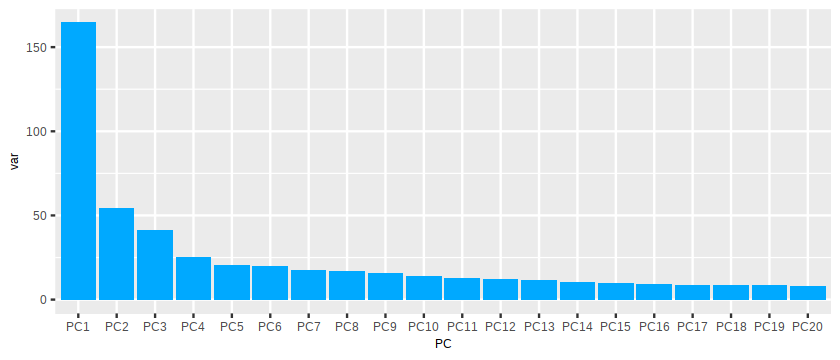

In [10]:
# Present a bar chart to visualize the variance of the first 20 principal components.
#
twenty_pcs = c("PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10", "PC11", "PC12", "PC13", "PC14", "PC15", "PC16", "PC17", "PC18", "PC19", "PC20")

pcs = as.data.frame(pc$x)
pcs.20 = pcs[,twenty_pcs]

variances = sapply(pcs.20, var)

df_variance = data.frame(pc=twenty_pcs,
                         var=variances)
df_variance$step = 1:nrow(df_variance)

ggplot(df_variance, aes(x=reorder(pc, step), y=var)) + geom_bar(stat="identity") + xlab("PC")


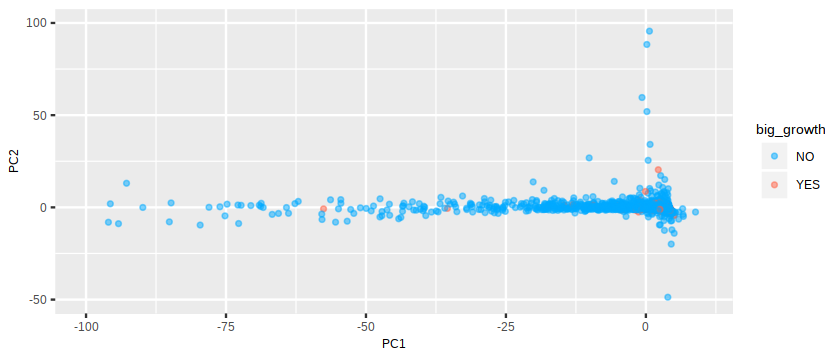

In [16]:
# Present a 2D scatterplot to visualize PC1 vs PC2 vs big_growth
# (for -100≤PC1≤10 on horizontal axis, -50≤PC2≤100 on vertical axis, 
# and big_growth color-coded).


first_two_pcs = data.frame(PC1=pcs.20$PC1,
                           PC2=pcs.20$PC2)
first_two_pcs$step = 1:nrow(first_two_pcs)

temp = data.frame(conm=data$conm,
                  big_growth=data$big_growth)
temp$step = 1:nrow(temp)

df2 = merge(temp, first_two_pcs, by="step")

ggplot(df2) + geom_point(alpha=0.5, aes(x=PC1, y=PC2, color=big_growth), na.rm=TRUE) + 
xlim(-100,10) + ylim(-50,100) + theme(legend.title = element_text(size=8))

### Transform the Data

In [17]:
# Change the representation of the data:
#   The first 3 columns are gvkey, tic, and conm; these are predictor variables
#   The next 2 columns are PC1 and PC2; these are predictor variables
#   The next 3 columns are prccq, growth, and big_growth; these are output variables
# Keep the names of the predictor variables for later use.
#
# How many observations and variables?
# How many predictor variables?
# How many outcome variables? 
# Present the few few observations of the resulting dataset.


temp2 = data.frame(gvkey=data$gvkey,
                   tic=data$tic,
                   conm=data$conm,
                   big_growth=data$big_growth,
                   prccq=data$prccq,
                   growth=data$growth)

temp2$step = 1:nrow(temp2)

df3 = merge(temp2, first_two_pcs, by="step")

df_transformed = df3[,c(2,3,4,8,9,6,7,5)]

size(df_transformed)

# We have 5 predictor variables (gvkey, tic, comn, pc1, and pc2),
# and 3 outcome variables (prccq, growth, big_growth)
variables = data.frame(length.prevars=5,
                       length.outvars=3)

variables

head(df_transformed, 5)


observations,variables
4305,8


length.prevars,length.outvars
5,3


gvkey,tic,conm,PC1,PC2,prccq,growth,big_growth
1004,AIR,AAR CORP,3.437123,-0.2260719,43.69,0.05074555,NO
1045,AAL,AMERICAN AIRLINES GROUP INC,-12.033207,0.8045109,32.11,-0.38285604,NO
1050,CECE,CECO ENVIRONMENTAL CORP,3.953223,-0.7553386,6.75,0.31578947,YES
1062,ASA,ASA GOLD AND PRECIOUS METALS,3.656143,-0.7981915,8.66,-0.21647395,NO
1072,AVX,AVX CORP,2.928223,-0.7104200,15.25,-0.11849711,NO


### Store Transformed Data & Transformation Meta-Data 

In [18]:
# Store the transformed data (4305 observations, 8 variables)
write.csv(df_transformed, "My Data.csv", row.names=FALSE)

In [19]:
# Store the variable names of the filtered data (923 predictor variable names)
saveRDS(names(data.filtered), "My Pre-Variables.rds")

In [20]:
# Store the imputation values (923 means and modes)
saveRDS(get_impute(data.filtered), "My Imputation.rds")

In [21]:
# Store the PCA centroids and weight matrix
saveRDS(pc, "My PC.rds")

In [22]:
# Store the predictor variable names of the transformed data (5 predictor variable names)
saveRDS(c("gvkey", "tic", "conm", "PC1", "PC2"), "My Post-Variables.rds")

<font size=1;>
<p style="text-align: left;">
Copyright (c) Berkeley Data Analytics Group, LLC
<span style="float: right;">
Document revised June 9, 2020
</span>
</p>
</font>